## CIFAR 10

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22
torch.backends.cudnn.benchmark = True
PATH = Path("../data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=128
sz=32

In [5]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

Here is a benchmark with SGD (usually giver result between 93.7% and 94% accuracy)

In [6]:
m = wrn_22()
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr = 1.5

In [6]:
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.216645   1.259887   0.5643    
    1      0.853854   0.969285   0.6612                      
    2      0.687803   1.179437   0.6241                      
    3      0.636611   0.96003    0.7075                      
    4      0.62562    0.645824   0.7792                      
    5      0.571705   0.942082   0.7031                      
    6      0.552434   0.77476    0.7599                      
    7      0.560228   0.688986   0.7645                      
    8      0.56225    1.016748   0.6826                      
    9      0.56433    0.653457   0.7712                      
    10     0.557705   0.832278   0.7108                      
    11     0.543039   0.738017   0.748                       
    12     0.550496   1.715083   0.5527                      
    13     0.543904   0.855024   0.7357                      
    14     0.491703   0.723532   0.7545                      
    15     0.506598   0.732

[0.19284258441925048, 0.9377]

Let's try Adam now.

In [6]:
m = wrn_22()
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
learn.opt_fn = optim.Adam

In [12]:
learn.save('init')

First with L2 regularization

In [7]:
learn.lr_find(wds=wd)

 87%|████████▋ | 342/391 [00:39<00:05,  8.76it/s, loss=7.21]

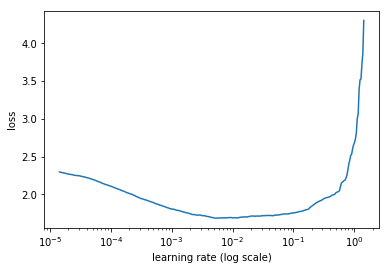

 87%|████████▋ | 342/391 [00:50<00:07,  6.84it/s, loss=7.21]

In [8]:
learn.sched.plot()

In [7]:
lr = 3e-3

In [10]:
learn.load('init')
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(10,7.5,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.076742   1.182316   0.5825    
    1      0.83687    0.842856   0.7071                      
    2      0.682173   0.929566   0.6896                      
    3      0.601082   0.725022   0.7524                      
    4      0.54762    0.739814   0.7556                      
    5      0.51929    0.610697   0.7994                      
    6      0.496448   0.656585   0.7864                      
    7      0.465956   0.555234   0.8131                      
    8      0.450089   0.540128   0.8175                      
    9      0.428163   0.574992   0.8085                      
    10     0.427882   0.530888   0.8178                      
    11     0.433119   0.613594   0.7999                      
    12     0.417986   0.473321   0.8451                      
    13     0.413969   0.486008   0.8416                      
    14     0.3866     0.570762   0.8122                      
    15     0.370618   0.455

[0.2414883628845215, 0.9294]

In [12]:
val_l2 = learn.sched.val_losses
met_l2 = learn.sched.rec_metrics

Now let's do weight decay.

In [16]:
learn.load('init')
learn.lr_find(wds=wd, use_wd_sched=True)

  1%|          | 2/391 [00:01<03:38,  1.78it/s, loss=2.3] 
epoch      trn_loss   val_loss   accuracy                   
    0      6.598559   239749.1965 0.1       



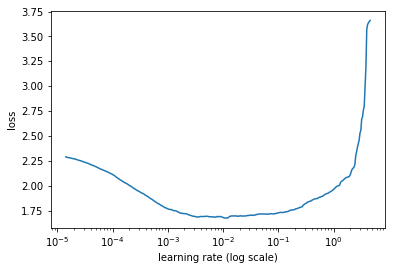

In [20]:
learn.sched.plot(10,20)

The same learning rate seems to work well.

In [14]:
learn.load('init')
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(10,7.5,0.95,0.85), use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                   
    0      1.066326   1.167119   0.5846    
    1      0.792451   0.971609   0.6661                      
    2      0.659506   0.720823   0.7552                      
    3      0.575499   0.639338   0.7809                      
    4      0.492047   0.508459   0.8246                      
    5      0.457091   0.674946   0.7819                      
    6      0.426951   0.492419   0.8362                      
    7      0.39474    0.503642   0.8332                      
    8      0.38039    0.513071   0.8259                      
    9      0.348871   0.382703   0.8714                      
    10     0.331633   0.398382   0.8689                      
    11     0.315192   0.411594   0.8648                      
    12     0.288207   0.445722   0.8592                      
    13     0.280894   0.432954   0.8647                      
    14     0.239715   0.366404   0.8823                      
    15     0.224879   0.341

[0.2674214375495911, 0.9402]

And here is the last 1% accuracy! We also get to 93% in 26 when it took 30 for the L2 reg.

In [15]:
val_wd = learn.sched.val_losses
met_wd = learn.sched.rec_metrics

In [16]:
epochs = list(range(1,31))

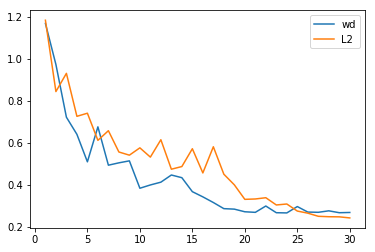

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(epochs, val_wd, label='wd')
ax.plot(epochs, val_l2, label='L2')
ax.legend(loc='upper right')

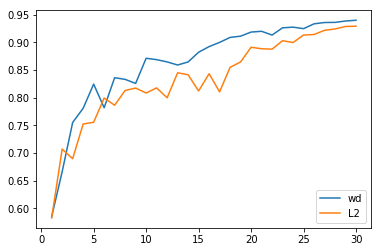

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(epochs, met_wd, label='wd')
ax.plot(epochs, met_l2, label='L2')
ax.legend(loc='lower right')

Now let's see how fast we can be to train the model to 94% accuracy! Tests showed that Adam works even better with the 1cycle policy if we lower the parameter beta2 to 0.99.

In [35]:
learn.load('init')
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
%time learn.fit(lr, 1, wds=wd, cycle_len=18, use_clr_beta=(10,7.5,0.95,0.85), use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                   
    0      1.073214   1.171766   0.5828    
    1      0.834694   0.904318   0.6898                      
    2      0.687177   0.784865   0.7437                      
    3      0.614023   0.619249   0.785                       
    4      0.5311     0.590406   0.8033                      
    5      0.476569   0.522703   0.8216                      
    6      0.439261   0.701453   0.7848                      
    7      0.410962   0.476661   0.8426                      
    8      0.367179   0.418149   0.863                       
    9      0.312993   0.374211   0.8724                      
    10     0.25478    0.322047   0.892                       
    11     0.214415   0.330291   0.8924                      
    12     0.17795    0.290726   0.9078                      
    13     0.146597   0.260588   0.9181                      
    14     0.104471   0.251844   0.925                       
    15     0.088235   0.249

[0.241928644323349, 0.9361]

In [36]:
def accuracy_with_TTA(learn):
    preds, targs = learn.TTA()
    probs = np.mean(np.exp(preds),0)
    return accuracy_np(probs, targs)

In [37]:
accuracy_with_TTA(learn)

0.939